# QAOA Test

As the last notebook was getting a little bigger than I would have wanted, I created a new notebook. I will transfer all the qaoa functions and the ones back in `test.ipynb` will probably become outdated.

The circuits and estimations used in this code are based on:

[1] Combarro, E. F., & Gonzalez-Castillo, S. (2023). A practical guide to quantum machine learning and quantum optimisation: Hands-On Approach to Modern Quantum Algorithms. Packt Publishing.

---

- **As of 10/12/2024 this file has become deprecated**

In [1]:
from qiskit.quantum_info import Pauli,SparsePauliOp,Statevector
from typing import Union
from colorama import Fore
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from qiskit.visualization import plot_histogram

In [2]:
def interaction_term(qc: QuantumCircuit, phi, control, target)->QuantumCircuit:
    r"""
    Builds the gate from the interaction term in the Ising Hamiltonian
    
    Args:
        `qc`: The quantum circuit to be added
        `phi`: The parameter $\phi$ from the optimization
        `control`: The position of the control qubit
        `target`: The position of the target qubit
    
    Returns:
        The modified QuantumCircuit    
    """
    
    qc.cx(control,target)
    qc.rz(phi*2,target)
    qc.cx(control,target)
    qc.barrier()
    
    return qc

def circuit_size(qc:QuantumCircuit)->int:
    r"""Utility function to get the number of registers of a QuantumCircuit"""
    size = 0
    for reg in qc.qregs:
        size+=reg.size
    return size
    

In [3]:
# Transforms a Pauli expression to a supported quadratic expression
def pauliop_to_exp(op:SparsePauliOp)->str:
    exp = ''
    for i,pauli in enumerate(op.paulis):
        exp+=str(int(op.coeffs[i].real))
        for i,char in enumerate(pauli.to_label()):
            if char == 'Z':
                exp+='Z'+str(i)
        exp+='+'
    exp = exp[:-1]
    return exp

In [4]:
# Function to automatize layers of an ansatz
def create_ansatz_layer(qc:QuantumCircuit,expression:Union[str,SparsePauliOp],phi=1,beta=1)->QuantumCircuit:
    r"""
    Creates an ansatz layer. However you need to start your circuit with h gates to enter superposition.
    
    Args:
        `qc`: QuantumCircuit to be modified.
        `expression`: Hamiltonian to optimize. Either in str or pauli expression.
        `phi`: Parameter for the Z rotations.
        `beta`: Parameter for the X rotations.
    
    Returns:
        The QuantumCircuit with the added ansatz.
    
    """
    if type(expression) == SparsePauliOp:
        expression = pauliop_to_exp(expression)
    #Read expression
    expression = expression.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    expression = expression.replace('-', '+-')
    if expression[0] == '+':
        expression = expression[1:]
    
    # Split the string into terms
    terms = expression.split('+')
    
    for term in terms:
        gate = term.count('Z')
        coefs = term.split('Z')
        if coefs[0] == '':
            coefs[0]=1
        if coefs[0] == '-':
            coefs[0]=-1
        coefs = [int(t) for t in coefs]
        if gate == 1:
            qc.rz(2*coefs[0]*phi,coefs[1])
            qc.barrier()
        else:
            qc = interaction_term(qc,coefs[0]*phi,coefs[1],coefs[2])
            
    size = circuit_size(qc)
    for i in range(size):
        qc.rx(2*beta,i)
    qc.barrier()
    return qc

# Create full ansatz (kind of stupid)
def create_ansatz(expression:str,qubits:int,layers=1,phi=[1],beta=[1]):
    r"""
    Creates an ansatz. However you need to start your circuit with h gates to enter superposition.
    
    Args:
        `expression`: Hamiltonian to optimize. Either in str or pauli expression.
        `qubits`: number of qubits of the circuit.
        `layers`:Number of layers to be added.
        `phi`: Parameter for the Z rotations. Needs to be of size == layers.
        `beta`: Parameter for the X rotations. Needs to be of size == layers.
    
    Returns:
        The QuantumCircuit with the added ansatz.
    
    Raises:
        ValueError: In case the size of the parameters is wrong.
    
    """
    qc = QuantumCircuit(qubits)
    for i in range(qubits):
        qc.h(i)
        
    if layers != len(phi) | layers!= len(beta):
        raise ValueError(f'For {layers} layers you need to input size {layers} parameters')
        
    for i in range(layers):
        qc = create_ansatz_layer(qc,expression,phi[i],beta[i])
    return qc

We can test if the code above works for both expression types

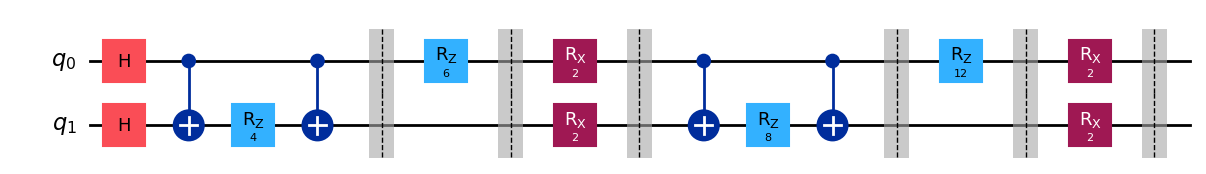

In [5]:
expression = "2Z0Z1+3Z0"
size = 2
    
qc=create_ansatz(expression,size,2,[1,2],[1,1])

qc.draw('mpl')

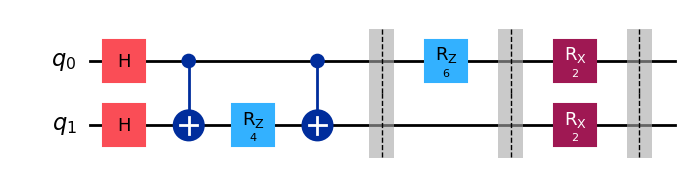

In [6]:
op = 2* SparsePauliOp(Pauli('ZZ'))+3*SparsePauliOp(Pauli('ZI'))

size = 2
    
qc=create_ansatz(op,size,1)

qc.draw('mpl')

## Energy estimation

After we have the circuit, we can run it, and calculate the energy level we need to minimize

In [7]:
def eval_energy(expression:Union[str,SparsePauliOp],factor:str):
    r"""
    Evaluates the energy of the factor given. This is the energy expectation from the state.
    
    Args:
        `expression`: Hamiltonian to optimize. Either in str or pauli expression.
        `factor`: Binary string to calculate the expectation value for the Hamiltonian.
    
    Returns:
    The energy value
    
    """
    energy = 0
    
    if type(expression) == SparsePauliOp:
        expression = pauliop_to_exp(expression)
        
    expression = expression.replace(' ', '')
    
    # Standardize the polynomial string to handle positive terms properly
    expression = expression.replace('-', '+-')
    if expression[0] == '+':
        expression = expression[1:]
    
    # Split the string into terms
    terms = expression.split('+')
    
    
    for term in terms:
        gate = term.count('Z')
        coefs = term.split('Z')
        if coefs[0] == '':
            coefs[0]=1
        if coefs[0] == '-':
            coefs[0]=-1
        coefs = [int(x) for x in coefs]
        if gate == 1:
            energy += (-2*int(factor[coefs[1]])+1)*coefs[0]
        else:
            energy += (2*np.abs(int(factor[coefs[1]])+int(factor[coefs[2]])-1)-1)*coefs[0]
    
    return energy

In [55]:
def get_energy(qc:QuantumCircuit,expression,shots=1024):
    """
    Returns the energy from an execution of a QuantumCircuit
    
    Args:
        `qc`: QuantumCircuit to run.
        `shots`: Number of shots for the circuit.
        
    Returns:
        The energy value.
    """
    
    # Define the simulator, in a future version, this would be a parameter
    sim = AerSimulator()
    
    # Transpile the circuit for the simulator or real QPU
    qc.measure_all()
    qc = transpile(qc,sim)

    # Run the circuit and collect results
    sampler = SamplerV2()
    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()

    # Using the formula from [1]
    energy = 0
    for key in counts:
        energy+= (counts[key]/shots)*eval_energy(expression,key)
    
    return energy

In [57]:
op = 2* SparsePauliOp(Pauli('ZZ'))+3*SparsePauliOp(Pauli('ZI'))

size = 2
    
qc=create_ansatz(op,size,1)

energy = get_energy(qc,op)

print(energy)

1.107421875


## Minimization process

After we can create and calculate the energy from a circuit, the next step should be to minimize the energy level to complete the QAOA algorithm. To do that we are going to create a function with the previous steps, that tries to minimize the energy modifying the parameters $\gamma_0,\ldots,\gamma_n$ and $\beta_0,\ldots,\beta_n$, when using a circuit with $n$ layers.

In [10]:
from scipy.optimize import minimize

In [59]:
def objective (x,exp,size,layers):
    
    # Setting up gamma and beta
    gamma = x[:layers]
    beta = x[layers:]
    
    qc = create_ansatz(exp,size,layers,gamma,beta)
    
    energy = get_energy(qc,exp)
    
    return energy

In [71]:
# Parameters that define the optimization problem
exp = 2* SparsePauliOp(Pauli('ZZ'))+3*SparsePauliOp(Pauli('ZI'))
size = 2
layers = 2
method = 'COBYLA'

# Define intial points
initial_guess = np.random.random(2*layers)

# Run minimization 
result = minimize(objective,initial_guess,args=(exp,size,layers),method=method)

# Display results
print("Optimal parameters:", result.x)
print("Minimum value:", result.fun)

Optimal parameters: [1.29518656 1.2627132  0.75315024 0.70205062]
Minimum value: -4.4765625


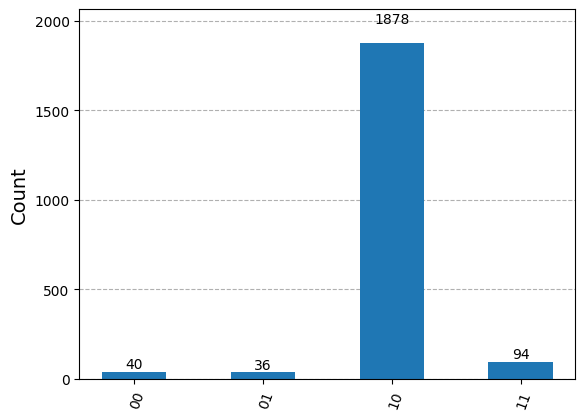

In [ ]:
gamma = result.x[:layers]
beta = result.x[layers:]

qc = create_ansatz(exp,size,layers,gamma,beta)

sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qc.measure_all()
qc = transpile(qc,sim)

# Run the circuit and collect results
sampler = SamplerV2()
job = sampler.run([qc],shots=2048)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()

plot_histogram(counts)



---

To better test if this process works, we can use statevectors instead of shots. This would effectively give us the exact energy level from the circuit.

In [90]:
def get_energy_statevector(qc:QuantumCircuit,expression):
    """
    Returns the energy from an execution of a QuantumCircuit
    
    Args:
        `qc`: QuantumCircuit to run.
        `shots`: Number of shots for the circuit.
        
    Returns:
        The energy value.
    """
    
    # Define the simulator, in a future version, this would be a parameter
    st = Statevector(qc)

    # Using the formula from [1]
    energy = 0
    for i in range(2**circuit_size(qc)):
        energy+= (st[i]**2).real*eval_energy(expression,f"{i:0{size}b}")
    
    return energy

def objective_statevector (x,exp,size,layers):
    
    # Setting up gamma and beta
    gamma = x[:layers]
    beta = x[layers:]
    
    qc = create_ansatz(exp,size,layers,gamma,beta)
    
    energy = get_energy_statevector(qc,exp)
    
    return energy

In [91]:
# Parameters that define the optimization problem
exp = 2* SparsePauliOp(Pauli('ZZ'))+3*SparsePauliOp(Pauli('ZI'))
size = 2
layers = 2
method = 'COBYLA'

# Define intial points
initial_guess = np.random.random(2*layers)

# Run minimization 
result = minimize(objective_statevector,initial_guess,args=(exp,size,layers),method=method)

# Display results
print("Optimal parameters:", result.x)
print("Minimum value:", result.fun)

Optimal parameters: [ 0.78941148  0.33512907  0.92491077 -0.00725265]
Minimum value: -4.698947144238817


In [97]:
gamma = result.x[:layers]
beta = result.x[layers:]

qc = create_ansatz(exp,size,layers,gamma,beta)

st = Statevector(qc)

print(st.data.real)

[-0.02423278 -0.09623193  0.68189759  0.03960933]


---

## Note

This notebook will no longer be used to update the functions. The methods in this notebook will be implemented by the file `qaoa_functions.py`, and thus become deprecated. No further development will be made in this file. As it is not an important file, this will be moved to a miscelaneous folder, because I want to keep the progress and evolution of the QAOA. 